# **Logistic Regression with a Neural Network Mindset**

Hi Professor, and welcome to your first interactive machine learning demo 😊 ! For today's exercise, I have created a notebook with instructions along the way to make this demo easy to follow along. 

For today, I decided to introduce you to one of the simplest and most important machine learning algorithms - **Logistic Regression**. We will be building a **cat classifer**, so let's get started!

## **What exactly is logistic regression?**

Logistic regression is a supervised regression algorithm which means it takes in data and outputs a discrete number. Let's take a look at the figure below:

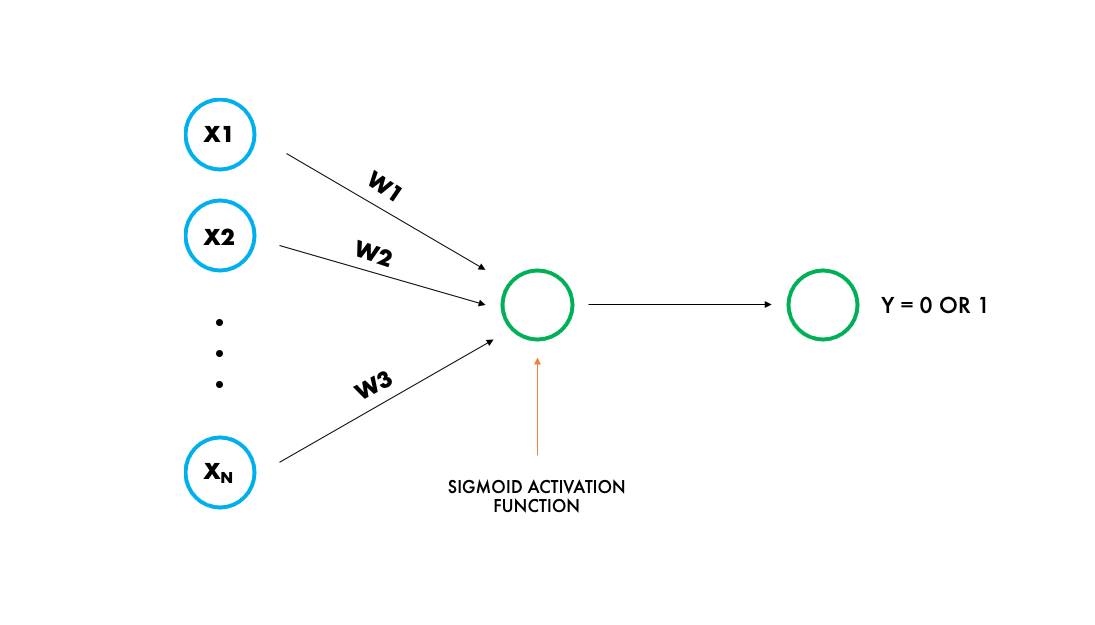
### **Some main takeaways from the figure:**


*   The model takes in **n number of features**.
*   These features are **multiplied by their corresponding weights**, then the **sum** of each product is taken (similar to the dot product). 
*  After this, to help the model learn more "complex" features a **non-linear activation** is applied to the result. In today's exerise, we will be using the sigmoid function. 
* Finally, a number is outputted from the model, **either 0 or 1**. Generally, 1 means that what you are looking for is true. For example, for the cat classifer, a 1 will represent that the image is a cat, and 0 will mean there is no cat.

Now that you understand what algorithm we will be using, let's get started!

## **Part 1 - Inserting and preprocessing data**

Let's first import all the packages and files that we will be using today. This is done for you to avoid any errors in importing. 








In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

### **Important information about the data:**


*   Training set has m images which are labeled as cat **(y=1)** or non-cat **(y=0)**
*   Test set has m images which are labelled as cat or non-cat
* Each image has the shape **(num_px, num_px, 3)** where 3 represents the different channels (red, blue, green - RGB). In this exercise, every image is a square since width = height. 

Now, let's load the data into our notebook.



In [ ]:
# Loading the data (cat/non-cat)

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()


In machine learning, it is essential to understand the data that you are dealing with. Let's visualize an example of one of the images.

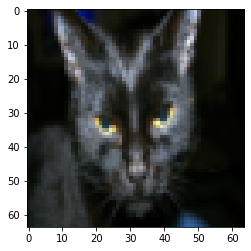

In [ ]:
# Example of a picture

plt.imshow(train_set_x_orig[25])


A lot of error in machine learning come from matrix/vector dimensions not fitting (lots of linear algebra!). Let's understand the dimensions of the matrices we will be working with.

In [ ]:
# Code starts here

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]


# Code ends here


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Now, we want to flatten the matrix that we see above, because we want rows to represent features (pixels), and the column to represent training examples. 


In [ ]:
# Code starts here

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
# Code ends here

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


One very common step in machine learning is to center and standarize the dataset. When your input features range from 0-1, it speeds up training and improves performace.

Generally, you would subtract the mean from each example, then divide by standard deviation. However, with picture datasets, each value is divided by 255 (standard convention). 

Let's standarize our picture dataset.

In [ ]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

## **2 - Building the model**

### **Creating helper functions**

We are first going to create small helper functions that will make our life easier when we build our model architecture. 

**Sigmoid Activation Function**

The first function we will write is the sigmoid activation function. This function is used in the activation process, after multiplying our inputs and weights (as discussed in the earlier figure). 

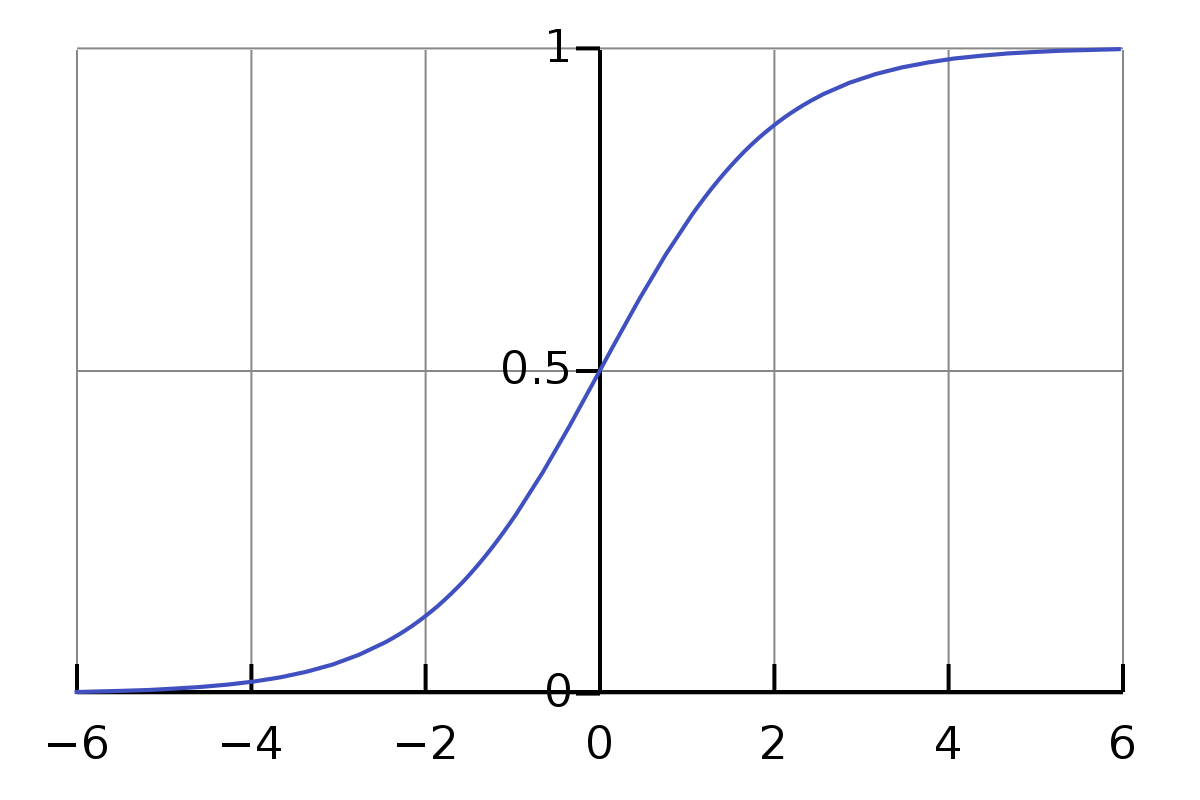

Basically, this activation function will compress our values from a range of 0 to 1 to ensure our output value is not too large or small.

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    # Code starts here
    
    s = 1 / (1 + np.exp(-z))

    # Code ends here
   
    return s

In [ ]:
# Test function
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Initializing parameters with zeros**

We must first initialize the weights of our matrix to a vector of zeros. 

In [ ]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    # Code starts here
    
    w = np.zeros((dim, 1))
    b = 0.0


    # Code ends here

    return w, b

In [ ]:
# Test function
dim = 2
w, b = initialize_with_zeros(dim)

print(w,b)

[[0.]
 [0.]] 0.0


### **Forward and Backward Propagation**

Now that our parameters are initialized, we can now "forward" and "back" propagate through our basic network.

Generally, the code for propagation is very long and complicated, but today's exercise is relatively simple, so we are able to implement both features into one function.

**Forward Propagation**

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Back Propagation**

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

These derivatives will be used in gradient descent (optimization algorithm) which we will see in optimize function later on.

In [ ]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # Code starts here

    # FORWARD PROPAGATION (FROM X TO COST)
  
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1/m) * (np.log(A).dot(Y.T) + (1 - Y).dot(np.log(1-A).T))
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    
    dw = (1/m) * np.dot(X, (A - Y).T)
    db = (1/m) * np.sum(A - Y)

    
    # Code ends here

    cost = np.squeeze(np.array(cost))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
# Test function
w =  np.array([[1.], [2.]])
b = 2.
X =np.array([[1., 2., -1.], [3., 4., -3.2]])
Y = np.array([[1, 0, 1]])
cost = propagate(w, b, X, Y)
print(cost)

({'dw': array([[0.99845601],
       [2.39507239]]), 'db': 0.001455578136784208}, array(5.80154532))


**Quick recap of everything we have done so far:**


*   Preprocessed the data
*   Intialized our parameters and created the sigmoid helper function
* Implemented forward and backward propagation
* Calculated the cost function and its derivatives

Now, you may be asking yourself, what do we do with these derivatives? The derivatives are used in an optimization algorithm known as gradient descent. 

Check out the visualization!

The goal of our algorithm is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.





In [ ]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    # Code starts here
    for i in range(num_iterations):

        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
       
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule

        w = w - learning_rate * dw
        b = b - learning_rate * db
        

   
   

        # Code ends here
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))

            
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
# Test function
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))



w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652
Costs = [array(5.80154532)]


### **Predict**

The previous function will output the learned weights and biases. Now, we are able to use these learned parameters to predict labels for any dataset.

There are two steps:


1.   Calculate the model's prediction $\hat{Y} = A = \sigma(w^T X + b)$
2.   Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. 



In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
  
    # YOUR CODE STARTS HERE

    A = sigmoid(w.T.dot(X) + b)

    bool = A >= 0.5
    Y_prediction[bool] = 1
        
    # YOUR CODE ENDS HERE
    
    return Y_prediction

In [ ]:
# Test function
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))



predictions = [[1. 1. 0.]]


## **Putting it all together** 🔨 

Now, it is time to put all of our building blocks together into one function!

Some notation:


*   `Y_prediction_test` for your predictions on the test set
*   `Y_prediction_train` for your predictions on the train set
*   `parameters`, `grads`, `costs` for the outputs of optimize()




In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # YOUR CODE STARTS HERE

    w,b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = params["w"]
    b = params["b"]

    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    

    
    # YOUR CODE ENDS HERE

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Now, it is time to train your model! 🏋 

In [ ]:
# Code starts here

logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

# Code ends here

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


Woo hoo 🎉  ! You have just created your first machine learning model!

**Some comments**: The training accuracy is incredibly high, but the test accuracy is low. This is because the model that we created was extremely simple, and usually more advanced algorithms are used for image classification. 

In addition to this, the model is also overfitting the training set. To address this, L2 regularization or dropout would be applied to fix this issue.

Now, let's look at a plot of the cost function and the number of iterations. 


In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

The cost function is decreasing after every iteration which is a good sign.

You may have noticed that when we were training our model we picked a particular learning rate (0.005). In order for gradient descent to work effectively, we must carefully pick the learning rate. 

Below, there is just some code that you can run to see the  results with different learning rates.

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Thanks for going through this exercise Professor! I hope you learned something new today! 🌱 



---




Exercise took inspiration from the deep learning specialzation course, and was tailored for you.